In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


## Read in the family information and sample submission

In [4]:
fpath = 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [5]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [8]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


## Exploring the Family Data

In [9]:
# Setting base date as Christmas Eve
import datetime
base = datetime.datetime(2019,12,24,00)

# Creating datelist for all 100 days before christmas
date_list = [base - datetime.timedelta(days=x) for x in range(100)]

In [10]:
# Creating date dataframe with day of week number (0 = Monday)
date_index = pd.DataFrame(date_list,columns=['date'])
date_index['day'] = date_index['date'].apply(lambda x: x.dayofweek)
date_index.index += 1 #aligning the index to days before Xmas
date_index[:5]

,date,day
1,2019-12-24,1
2,2019-12-23,0
3,2019-12-22,6
4,2019-12-21,5
5,2019-12-20,4


## Exploring the distribution of choice_0 requests below, Xmas Eve is the overwhelming choice and weekends (Fri-Sun) are popular as well

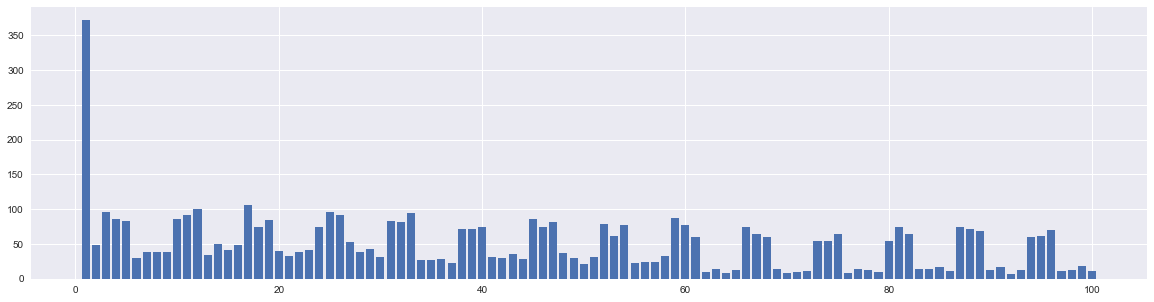

In [12]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

bar = ax.bar(data.groupby('choice_0')['choice_0'].count().index,data.groupby('choice_0')['choice_0'].count().values)

In [13]:
# Creating column with day of week for choice_0
date_dict = date_index.day.to_dict()
data['choice_0_day']= data['choice_0'].map(date_dict)

## Validating most preferences are for Friday, Saturday, Sunday. Tuesday is Christmas Eve

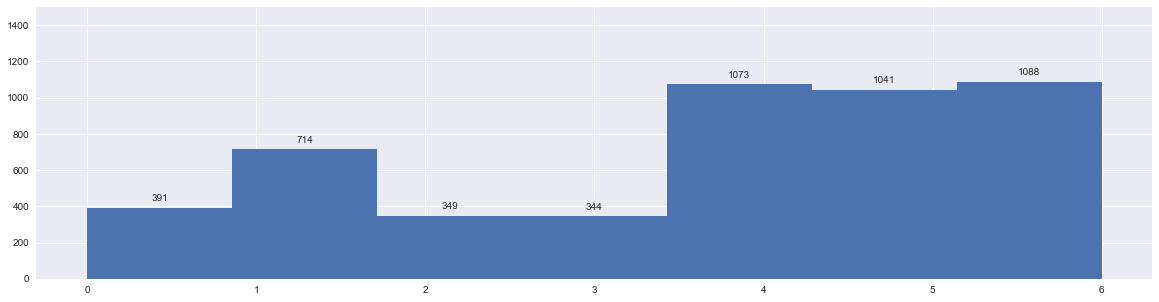

In [14]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

hist = ax.hist(data['choice_0_day'].astype('int'),bins=7)
ax.set(ylim=(0,1500))

add_value_labels(ax)

## I need to create some functions to help approxiate cost and stay within the bounds

In [16]:
# Given cost function for families not getting their desired preferences
def top_pref_penalty(pref,d):
    
    penalty = 0
    n = pref
    
    d = d
    if pref > 0:
        if d == 0:
            penalty += 0
        elif d == 1:
            penalty += 50
        elif d == 2:
            penalty += 50 + 9 * n
        elif d == 3:
            penalty += 100 + 9 * n
        elif d == 4:
            penalty += 200 + 9 * n
        elif d == 5:
            penalty += 200 + 18 * n
        elif d == 6:
            penalty += 300 + 18 * n
        elif d == 7:
            penalty += 300 + 36 * n
        elif d == 8:
            penalty += 400 + 36 * n
        elif d == 9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    else:
        pass
        
    return penalty

In [17]:
# Daily limit function to ensure all days have at least 125 people and at most 300 
# (can mess with parameters to change cost)
def daily_limit(choice,n_people,pref,remaining):

    min_choice = occupancy['total'].idxmin() #for any unassigned families, put them in smallest bucket
    
    # Looping through all family choices until finding match and ensuring buckets get filled to 150 at least
    if occupancy.loc[choice]['total'] + n_people <= 300 and pref < 9:
        if remaining > occupancy[occupancy['total'] < 125]['total'].sum() + n_people:
            if occupancy.loc[choice]['total'] < 225: # Can add people to bucket with less than the min
                occupancy.loc[choice]['pref_{}'.format(pref)] += n_people
                occupancy.loc[choice]['total'] += n_people
                return 1 #Should stop iterating when adding to occupancy df
            else:
                return 0
        else:
            return 0 #Should continue iterating through choices when buckets need to be filled
        
    if occupancy.loc[choice]['total'] + n_people <= 300 and pref == 9:
        occupancy.loc[min_choice]['pref_10'] += n_people # this needs to be updated to account for actual preference when its the same (or maybe top 10 buckets?)
        occupancy.loc[min_choice]['total'] += n_people
        return 2
    
    else:
        return 0 #Should continue iterating through choices

## Looking at how cost changes based on preference, ensuring people do not get choice 9 or no choice is ideal to keep cost down

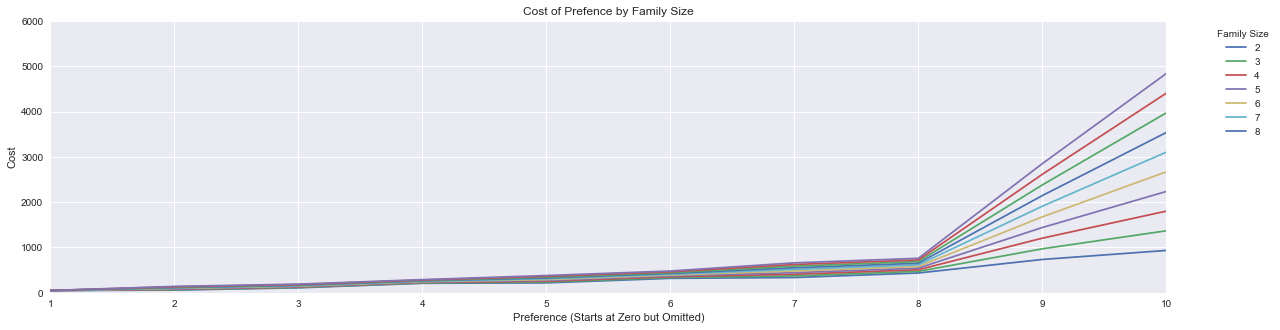

In [18]:
# Setting average family size
fam_size = sorted(list(data['n_people'].unique()))
pref = range(1,11)

# Labels for stacked plot
labels = fam_size

pref_0 = [top_pref_penalty(0,d) for d in pref]
pref_1 = [top_pref_penalty(1,d) for d in pref]
pref_2 = [top_pref_penalty(2,d) for d in pref]
pref_3 = [top_pref_penalty(3,d) for d in pref]
pref_4 = [top_pref_penalty(4,d) for d in pref]
pref_5 = [top_pref_penalty(5,d) for d in pref]
pref_6 = [top_pref_penalty(6,d) for d in pref]
pref_7 = [top_pref_penalty(7,d) for d in pref]
pref_8 = [top_pref_penalty(8,d) for d in pref]
pref_9 = [top_pref_penalty(9,d) for d in pref]
pref_10 = [top_pref_penalty(10,d) for d in pref]


# Setting figure
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Preference (Starts at Zero but Omitted)')
ax.set_ylabel('Cost')
ax.set_ylim(0,6000)
ax.set_xlim(1,10)

# Creating plot
# ax0 = ax.plot(pref,pref_0)
ax1 = ax.plot(pref,pref_1)
ax2 = ax.plot(pref,pref_2)
ax3 = ax.plot(pref,pref_3)
ax4 = ax.plot(pref,pref_4)
ax5 = ax.plot(pref,pref_5)
ax6 = ax.plot(pref,pref_6)
ax7 = ax.plot(pref,pref_7)
ax8 = ax.plot(pref,pref_8)
ax9 = ax.plot(pref,pref_9)
ax10 = ax.plot(pref,pref_10)

ax.legend(labels=labels,loc=1,bbox_to_anchor=(1.1, 1),title='Family Size')
ax.set_title('Cost of Prefence by Family Size')

plt.show()

## Omitting preference 9 and 10 sheds more light on the better preferences and established a sweet spot of preference 0-3 for all family sizes

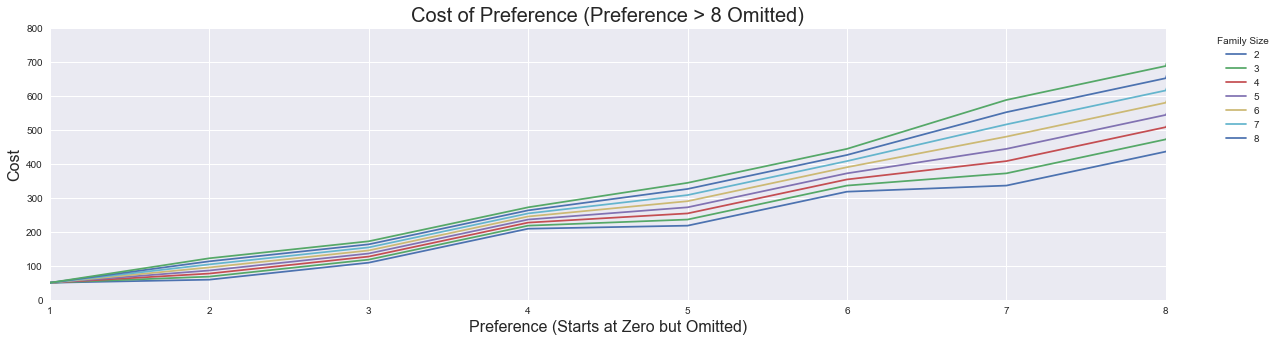

In [287]:
# Setting figure
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Preference (Starts at Zero but Omitted)',fontsize=16)
ax.set_ylabel('Cost',fontsize=16)
ax.set_ylim(0,800)
ax.set_xlim(1,8)

# Creating plot
# ax0 = ax.plot(pref,pref_0)
ax1 = ax.plot(pref,pref_1)
ax2 = ax.plot(pref,pref_2)
ax3 = ax.plot(pref,pref_3)
ax4 = ax.plot(pref,pref_4)
ax5 = ax.plot(pref,pref_5)
ax6 = ax.plot(pref,pref_6)
ax7 = ax.plot(pref,pref_7)
ax8 = ax.plot(pref,pref_8)

ax.legend(labels=labels,loc=1,bbox_to_anchor=(1.1, 1),title='Family Size')
ax.set_title('Cost of Preference (Preference > 8 Omitted)',fontsize=20)

plt.show()

## Exploring Accounting Cost Behavior:
##### Exploring Accounting Cost, we see Accounting Cost rises exponentially as the daily delta rises. It would behoove us to minimize daily deltas and stay within 20-30 people as the previous day

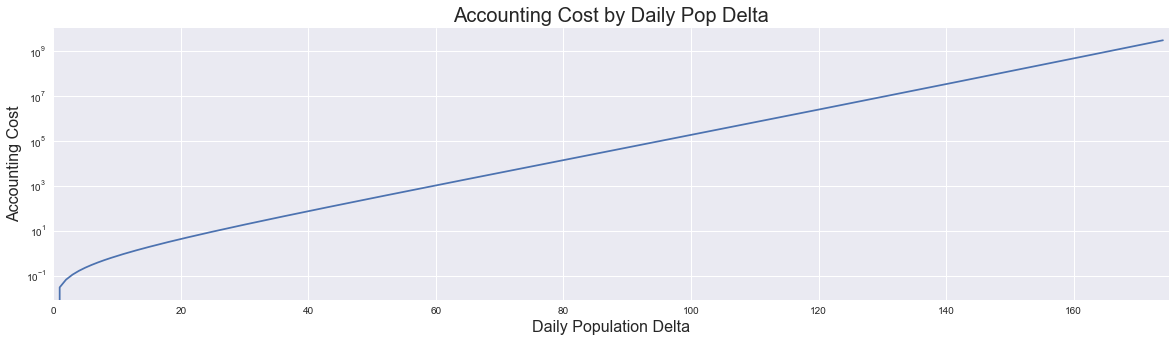

In [293]:
pop_range = range(125,300)

cost = [max(0, (x-125.0) / 400.0 * x**(0.5 + (x-125) / 50.0)) for x in pop_range]
        
pop_delta = range(0,175)

# Setting figure
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Daily Population Delta',fontsize=16)
ax.set_ylabel('Accounting Cost',fontsize=16)
# ax.set_ylim(0,800)
ax.set_yscale('log')
ax.set_xlim(0,175)

# Creating plot
# ax0 = ax.plot(pref,pref_0)
ax1 = ax.plot(pop_delta,cost)

ax.set_title('Accounting Cost by Daily Pop Delta',fontsize=20)

plt.show()

## Assigning Days Based off Preference and Daily Occupancy Limits (initial evaluation):

In [20]:
# Testing logic for dynamically looking at choices
j = 0

# Creating occupancy dataframe to capture daily attendance by preference
columns = ['pref_0', 'pref_1', 'pref_2', 'pref_3', 'pref_4', 'pref_5',
       'pref_6', 'pref_7', 'pref_8', 'pref_9','pref_10','total']
occupancy = pd.DataFrame(0,index=date_index.index,columns=columns)

# Create submission dataframe
submission = pd.DataFrame(data,columns=['assigned_day','pref'])

remaining = 20968 # total number of people

for index,row in data.iterrows():
    for i in range(10):
        choice = row['choice_{}'.format(i)]
        n_people = row['n_people']
        family_id = index
        
        # Runs occupancy filling function from highlest to lowest preference
        add_check = daily_limit(choice,n_people,i,remaining)
        
        if add_check == 1:
            remaining -= n_people # Removing added people
            submission.iloc[family_id] = choice.astype('int')
            submission.iloc[family_id]['pref'] = i
            break
        if add_check == 2:
            remaining -= n_people # Removing added people
            min_choice = occupancy['total'].idxmin() # for any unassigned families, put them in smallest bucket
            submission.iloc[family_id]['assigned_day'] = min_choice
            submission.iloc[family_id]['pref'] = 10
            break
        if add_check == 0:
            pass
        else:
            assert False, 'Error with add_check'

In [23]:
# Initializing Preference Penalty Cost column by day
occupancy['pref_pen'] = 0

# Apply preference penalty across all preference columns (pref_#) and sums to one column
for i in range(11):
    occupancy['pref_pen'] += occupancy.apply(lambda x: top_pref_penalty(x['pref_{}'.format(i)],i),axis=1)

In [24]:
occupancy.head()

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total,pref_pen
1,227,0,0,0,0,0,0,0,0,0,0,227,0
2,170,14,12,5,7,14,0,4,0,0,0,226,1512
3,224,6,0,0,0,0,0,0,0,0,0,230,50
4,207,16,0,0,0,3,0,0,0,0,0,226,304
5,206,16,4,0,0,0,0,0,0,0,0,226,136


## Plotting Preference Given By Day Before Xmas:
##### Plotting preference by day after initial run shows most people are getting a better preference near Xmas (most likely due to the volume of preferences on those days), but the further we move away, more people are being added to non-requested days to account for minimum daily volumes of 125 people. Also, weekdays have high percentages of no preference given, which is very expensive

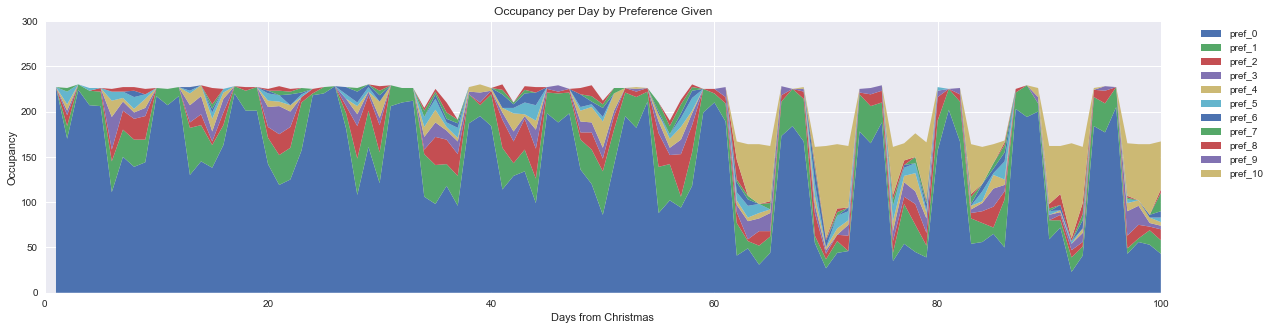

In [290]:
plt.close('all')
plt.style.use('seaborn')

# Labels for stacked plot
labels = list(occupancy.columns)[:11]

# Creating individual lists for each preference (required for stacked plot)
pref_0 = list(occupancy['pref_0'].values)
pref_1 = list(occupancy['pref_1'].values)
pref_2 = list(occupancy['pref_2'].values)
pref_3 = list(occupancy['pref_3'].values)
pref_4 = list(occupancy['pref_4'].values)
pref_5 = list(occupancy['pref_5'].values)
pref_6 = list(occupancy['pref_6'].values)
pref_7 = list(occupancy['pref_7'].values)
pref_8 = list(occupancy['pref_8'].values)
pref_9 = list(occupancy['pref_9'].values)
pref_10 = list(occupancy['pref_10'].values)

# Getting days from Occupancy dataframe
x = list(occupancy.index.values)

# Setting figure
fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Days from Christmas')
ax.set_ylabel('Occupancy')
ax.set_ylim(0,300)
ax.set_xlim(0,100)

# Creating plot
ax.stackplot(x,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,labels=labels)
ax.legend(loc=1,bbox_to_anchor=(1.1, 1))
ax.set_title('Occupancy per Day by Preference Given')

plt.show()

## Accounting cost for all days:
##### Accounting costs grow exponentially when the gap between daily volumes is large, as we see with the days further way from Xmas

In [26]:
occupancy['acct_cost'] = 0
days = list(range(1,101,1))

# First day is special
occupancy.loc[days[0]]['acct_cost'] = (occupancy.loc[days[0]]['total']-125.0) / 400.0 *\
                                       occupancy.loc[days[0]]['total']**(0.5)

# Loop over the rest of the days, keeping track of previous count
yesterday_count = occupancy.loc[days[0]]['total']
for day in days[1:]:

    today_count = occupancy.loc[day]['total']
    diff = abs(today_count - yesterday_count)
    occupancy.loc[day]['acct_cost'] = max(0., (occupancy.loc[day]['total']-125.0) / 400.0 *\
                                              occupancy.loc[day]['total']**(0.5 + diff / 50.0))
    yesterday_count = today_count

occupancy.tail()

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total,pref_pen,acct_cost
96,205,22,0,0,0,0,0,0,0,0,0,227,50,4
97,43,6,14,27,9,4,0,2,2,0,58,165,27638,721
98,56,4,15,21,6,0,0,0,0,0,62,164,28186,1
99,53,16,4,4,6,0,3,0,0,0,78,164,35232,1
100,43,15,12,4,4,5,7,20,4,0,53,167,26362,1


In [27]:
# First day accounting cost (Just checking logic)
np.round(max(0,(300-125.0) / 400.0 * 300**(0.5)),2)

7.58

## Summarizing Cost and Creating Initial Submission:
##### Initial submission estimated cost of 710K is lower than the scored cost of 943K

In [353]:
occupancy['total_cost'] = occupancy['pref_pen'] + occupancy['acct_cost']
score = occupancy['total_cost'].sum()
submission['assigned_day'] = pd.to_numeric(submission['assigned_day']).astype('int')
submission['pref'] = pd.to_numeric(submission['pref']).astype('int')

submission[['assigned_day']].to_csv(f'submission_{score}.csv')
print('{0:,}'.format(score))

710,757


## Cost Optimization:
##### In the next section, we will attempt to re-assign families to more cost effective days and bring down overall cost. We will focus on re-assigned preference 8 and above to a more preferred day, without violating daily limits and drastically increasing Accounting Cost

In [29]:
# Looking at data dataframe sample again as we begin (will remove once everything works correctly)
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,choice_0_day
family_id,,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4,6
1,26,4,82,5,11,47,38,6,66,61,4,4
2,100,54,25,12,27,82,10,89,80,33,3,0
3,2,95,1,96,32,6,40,31,9,59,2,0
4,53,1,47,93,26,3,46,16,42,39,4,5


In [46]:
# Creating occupancy delta dataframe to add limits for changes
occupancy_count = pd.DataFrame(0, index=range(1,101), columns=['delta'])
occ_copy = occupancy.copy(deep=True)
occupancy_small = pd.DataFrame(occupancy['total'])

# Creating copy of submission to compare results
submission2 = submission.copy(deep=True)

# Creating smaller submission dataframe to try to re-arrange requests with preference greater 7
submission_small = submission[submission.pref > 7].sort_values(by=['pref','assigned_day'],ascending=[False,True])

for index,row in submission_small.iterrows():
    for i in range(1,9):
#         occupancy_small = occ_copy['total'] # needs to reset after every check
        family_id = index
        n_people = data.loc[family_id]['n_people'] # Getting family size using family_id
        
        
        new_pref = i # Preference of current i in loop
        current_pref = row['pref'].astype('int') # Current preference for current assigned day
        
        new_day = data.loc[index]['choice_{}'.format(i)] # Find preferred day by choice in data dataframe
        current_day = row['assigned_day'] # Current assigned day in submission_small dataframe
        
        #print(current_day)
#         try:
        
        if (list(occupancy_small.loc[current_day])[0] - n_people >= 125) &\
            (list(occupancy_small.loc[new_day])[0] + n_people <= 300) &\
            (abs(list(occupancy_count.loc[new_day])[0]) <= 10) &\
            (abs(list(occupancy_count.loc[current_day])[0]) <= 10):
            
            occ_copy.loc[new_day]['pref_{}'.format(i)] += n_people
            occ_copy.loc[new_day]['total'] += n_people

            occ_copy.loc[current_day]['pref_{}'.format(current_pref)] -= n_people
            occ_copy.loc[current_day]['total'] -= n_people

            submission2.loc[family_id]['assigned_day'] = new_day
            submission2.loc[family_id]['pref'] = new_pref
            
            occupancy_count.loc[new_day]['delta'] += n_people
            occupancy_count.loc[current_day]['delta'] -= n_people

            break

        else:
#                 print('first: {}, second: {}, third: {}, fourth: {}'\
#                       .format((occupancy_small.iloc[current_day] - n_people),\
#                              (occupancy_small.iloc[new_day] + n_people),\
#                              (list(abs(occupancy_count.iloc[new_day]).values)[0]),\
#                              (list(abs(occupancy_count.iloc[current_day]).values)[0])
#                              ))
            pass

#         except:
#             print('Current Day: {}, Current Pref: {}, New Day: {}, , New Pref: {}, Family_id: {}, n_people: {}'\
#               .format(current_day,current_pref,new_day,new_pref,family_id,n_people))


##### Re-plotting our occupancy dataframe (occ_copy) doesn't obviously show any improvements, but it doesn't violate our Daily Occupancy Limit conditions

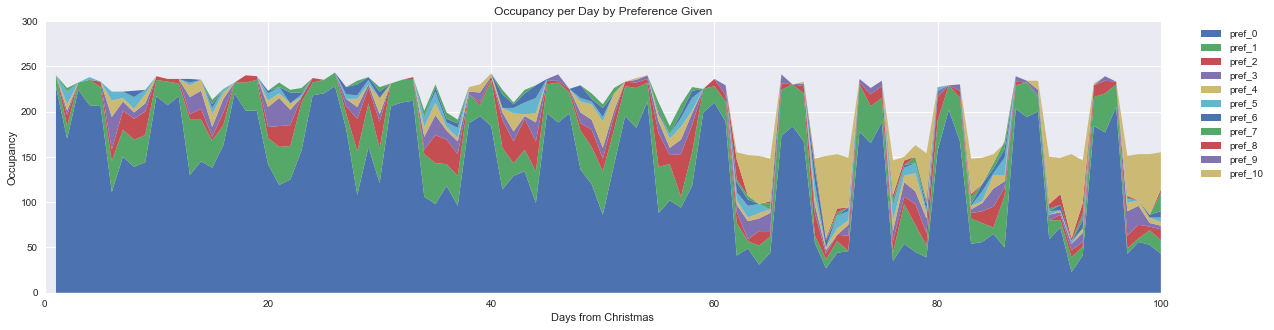

In [47]:
plt.close('all')
plt.style.use('seaborn')

# Labels for stacked plot
labels = list(occ_copy.columns)[:11]

# Creating individual lists for each preference (required for stacked plot)
pref_0 = list(occ_copy['pref_0'].values)
pref_1 = list(occ_copy['pref_1'].values)
pref_2 = list(occ_copy['pref_2'].values)
pref_3 = list(occ_copy['pref_3'].values)
pref_4 = list(occ_copy['pref_4'].values)
pref_5 = list(occ_copy['pref_5'].values)
pref_6 = list(occ_copy['pref_6'].values)
pref_7 = list(occ_copy['pref_7'].values)
pref_8 = list(occ_copy['pref_8'].values)
pref_9 = list(occ_copy['pref_9'].values)
pref_10 = list(occ_copy['pref_10'].values)

# Getting days from Occupancy dataframe
x = list(occ_copy.index.values)

# Setting figure
fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Days from Christmas')
ax.set_ylabel('Occupancy')
ax.set_ylim(0,300)
ax.set_xlim(0,100)

# Creating plot
ax.stackplot(x,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,labels=labels)
ax.legend(loc=1,bbox_to_anchor=(1.1, 1))
ax.set_title('Occupancy per Day by Preference Given')

plt.show()

##### Our largest swings in re-organizing happen further way from Xmas, where we already have some very low buckets

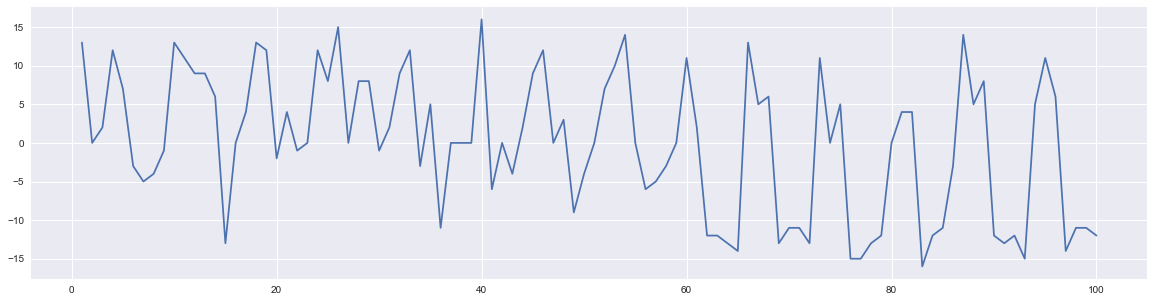

In [48]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

ax = ax.plot(occupancy_count.index,occupancy_count['delta'])

## Summarizing Cost and Creating Revised Submission:
##### Initial submission estimated cost of 710K

In [53]:
# Re-calculate preference penalty
occ_copy['pref_pen'] = 0

# Applies preference penalty across all preference columns (pref_#) and sums to one column
for i in range(11):
    occ_copy['pref_pen'] += occ_copy.apply(lambda x: top_pref_penalty(x['pref_{}'.format(i)],i),axis=1)
    
# Re-calculate accounting penalty
occ_copy['acct_cost'] = 0
days = list(range(100,0,-1))

# First day is special
occ_copy.loc[days[0]]['acct_cost'] = (occ_copy.loc[days[0]]['total']-125.0) / 400.0 *\
                                       occ_copy.loc[days[0]]['total']**(0.5)

# Loop over the rest of the days, keeping track of previous count
yesterday_count = occ_copy.loc[days[0]]['total']
for day in days[1:]:
    today_count = occ_copy.loc[day]['total']
    diff = abs(today_count - yesterday_count)
    occ_copy.loc[day]['acct_cost'] = max(0, (occ_copy.loc[day]['total']-125.0) / 400.0 *\
                                              occ_copy.loc[day]['total']**(0.5 + diff / 50.0))
    yesterday_count = today_count

occ_copy['total_cost'] = occ_copy['pref_pen'] + occ_copy['acct_cost']
score = occ_copy['total_cost'].sum()

submission2[['assigned_day']].to_csv(f'submission_{score}.csv')
print('{0:,}'.format(score))

785,744


# Code from starter book

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [46]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [42]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}

    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

## Simple Opimization Approach

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [43]:
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_score = cost_function(best)

new = best.copy()
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        if cost_function(temp) < start_score:
            new = temp.copy()
            start_score = cost_function(new)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

Score: 736542.7844967854


# Scrap

In [39]:
# Creating my empty occupancy dataframe for controlling limits
occupancy = pd.DataFrame(0,index=date_index.index,columns=['occ_count'])
occupancy

,occ_count
1,0
2,0
3,0
4,0
5,0
...,...
96,0
97,0
98,0
99,0


In [40]:
# Creating trimmed dataframe of non-peak requests (Mon-Thur) and non-Xmas Eve
non_weekend_or_xmas = data.where(~data.choice_0_day.isin([4,5,6])&data.choice_0_day != 1).dropna()
non_weekend_or_xmas.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,choice_0_day
family_id,,,,,,,,,,,,
0,52.0,38.0,12.0,82.0,33.0,75.0,64.0,76.0,10.0,28.0,4.0,6.0
1,26.0,4.0,82.0,5.0,11.0,47.0,38.0,6.0,66.0,61.0,4.0,4.0
2,100.0,54.0,25.0,12.0,27.0,82.0,10.0,89.0,80.0,33.0,3.0,0.0
3,2.0,95.0,1.0,96.0,32.0,6.0,40.0,31.0,9.0,59.0,2.0,0.0
4,53.0,1.0,47.0,93.0,26.0,3.0,46.0,16.0,42.0,39.0,4.0,5.0


In [41]:
# Adding non-peak requests to occupancy dataframe
for index,row in non_weekend_or_xmas.iterrows():
    occupancy['occ_count'][row['choice_0']] += row['n_people']
#     print(index,row['n_people'])

In [18]:
# loops = 100
# for i in range(100):
#     data['picked_choice_{}'.format(i)] = 10
#     data['picked_day_{}'.format(i)] = -2
    